In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import multiprocessing
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data

In [3]:
all_data = pd.read_csv('complaints.csv').dropna(subset=['Consumer complaint narrative'])
all_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392.0
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198.0
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555.0
4,2019-07-18,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,I started the process to refinance my current ...,Company has responded to the consumer and the ...,Freedom Mortgage Company,NC,275XX,NaN,Consent provided,Web,2019-07-18,Closed with explanation,Yes,NaN,3311105.0
6,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,914XX,NaN,Consent provided,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331.0


In [4]:
all_data.Product.describe()

count                                                  9183
unique                                                   14
top       Credit reporting, credit repair services, or o...
freq                                                   4030
Name: Product, dtype: object

In [5]:
all_data['Consumer complaint narrative'][6]

'Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/XX/XXXX I requested that Experian send me a copy of the verifiable proof they have on file showing that the XXXX account they have listed on my credit report is actually mine. On XX/XX/XXXX and XX/XX/XXXX, instead of sending me a copy of the verifiable proof that I requested, Experian sent me a statement which reads, " The information you disputed has been verified as accurate. \'\' Experian also failed to provide me with the method of " verification. \'\' Since Experian neither provided me with a copy of the verifiable proof, nor did they delete the unverified information, I believe they are in violation of the Fair Credit Reporting Act and I have been harmed as a result. I have again, today, sent my fourth and final written request that they verify the account, and send me verifiable proof that this account is mine, or that they delete the unverified account. If they do not, my next step is to pursue a remedy through litigation.'

# ZAD1
#### Proszę znaleźć i porównać przynajmniej 2 metody obliczania reprezentacji wektorowej tekstu na podstawie osadzeń słów. Proszę je przetestować na klasyfikacji wieloklasowej tekstu.

Wybrałem zbiór [*Consumer Complaint Database*](https://catalog.data.gov/dataset/consumer-complaint-database)
w którym dokonam klasyfikacji rodzaju produktu (Product) na podstawie skargi (Consumer complaint narrative) przy użyciu Doc2Vec i TF-IDF.


In [6]:
data = all_data[['Product', 'Consumer complaint narrative']]
data.rename(columns={'Consumer complaint narrative': 'Complaint'}, inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Product,Complaint
0,Debt collection,transworld systems inc. \nis trying to collect...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,Debt collection,Pioneer has committed several federal violatio...
4,Mortgage,I started the process to refinance my current ...
6,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/..."


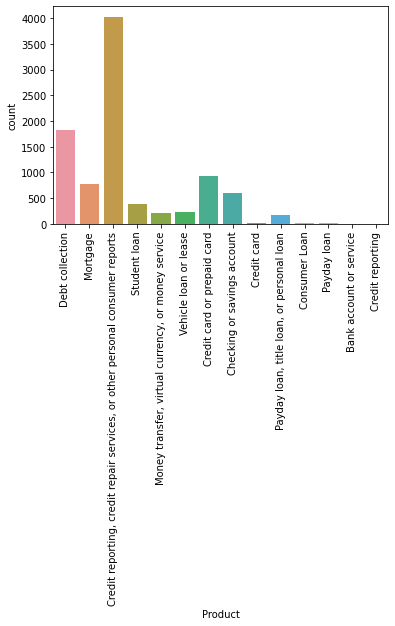

In [7]:
sns.countplot(x="Product", data=data)
plt.xticks(rotation=90)
plt.show()

In [8]:
tags = ['URL', 'DATE', 'CONF']
def preprocess_text(text):
    #clean URL
    text = re.sub(r'http/S+', r'URL', text)
    #clean date
    text = re.sub(r'(XX/XX/XXXX)|(XX/XX/\d\d\d\d)', r'DATE', text)
    #delete \n
    text = re.sub(r'\n', r' ', text)
    #some confidential data
    text = re.sub(r'XXXX', r'CONF', text)
    return text

data.Complaint = data.Complaint.apply(preprocess_text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
data.Complaint[6]

'Previously, on DATE, DATE, and DATE I requested that Experian send me a copy of the verifiable proof they have on file showing that the CONF account they have listed on my credit report is actually mine. On DATE and DATE, instead of sending me a copy of the verifiable proof that I requested, Experian sent me a statement which reads, " The information you disputed has been verified as accurate. \'\' Experian also failed to provide me with the method of " verification. \'\' Since Experian neither provided me with a copy of the verifiable proof, nor did they delete the unverified information, I believe they are in violation of the Fair Credit Reporting Act and I have been harmed as a result. I have again, today, sent my fourth and final written request that they verify the account, and send me verifiable proof that this account is mine, or that they delete the unverified account. If they do not, my next step is to pursue a remedy through litigation.'

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
stopwords_en = stopwords.words('english')

def tag_text(text):
    tags = []
    for sentence in sent_tokenize(text):
        for word in word_tokenize(sentence):
            word = word.lower()
            if word not in tags and word not in stopwords_en and word.isalpha():
                tags.append(word.lower())            
    return tags

data.Complaint = data.Complaint.apply(tag_text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
data.Complaint[6]

['previously',
 'date',
 'requested',
 'experian',
 'send',
 'copy',
 'verifiable',
 'proof',
 'file',
 'showing',
 'conf',
 'account',
 'listed',
 'credit',
 'report',
 'actually',
 'mine',
 'instead',
 'sending',
 'sent',
 'statement',
 'reads',
 'information',
 'disputed',
 'verified',
 'accurate',
 'also',
 'failed',
 'provide',
 'method',
 'verification',
 'since',
 'neither',
 'provided',
 'delete',
 'unverified',
 'believe',
 'violation',
 'fair',
 'reporting',
 'act',
 'harmed',
 'result',
 'today',
 'fourth',
 'final',
 'written',
 'request',
 'verify',
 'next',
 'step',
 'pursue',
 'remedy',
 'litigation']

# Doc2Vec

In [13]:
train, test = train_test_split(data, test_size=0.3)
d2v_train = train.apply(lambda x: TaggedDocument(words=x.Complaint, tags=x.Product), axis=1)
d2v_test = test.apply(lambda x: TaggedDocument(words=x.Complaint, tags=x.Product), axis=1)

## DBOW

In [173]:
def train_DBOW():
    cores = multiprocessing.cpu_count()
    MAX_EPOCHS = 25

    dbow_100 = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, window=10, workers=cores, dbow_words=1, batch_words=1000)
    dbow_100.build_vocab(d2v_train.values)
    
    total_exaples = len(d2v_train.values)
    for epoch in range(MAX_EPOCHS):
        print(f'Epoch {epoch} starting')
        start = timer()

        dbow_100.train(d2v_train.values, total_examples=total_exaples, epochs=1)
        dbow_100.alpha -= 0.004
        dbow_100.min_alpha = dbow_100.alpha

        end = timer()
        print(f'Finished in {end-start}s')
    # dbow_100.save('dbow100.model')
    return dbow_100
        
dbow_100 = train_DBOW()
# dbow_100 = Doc2Vec.load('dbow100.model')
    

Epoch 0 starting


Finished in 1.1175577789999807s
Epoch 1 starting
Finished in 1.0984798030001457s
Epoch 2 starting
Finished in 1.0577676539999175s
Epoch 3 starting
Finished in 1.050455606000014s
Epoch 4 starting
Finished in 1.0482751910001298s
Epoch 5 starting
Finished in 1.0565065869998307s
Epoch 6 starting
Finished in 1.0673797980000472s
Epoch 7 starting
Finished in 0.8479912160000822s
Epoch 8 starting
Finished in 0.734057890000031s
Epoch 9 starting
Finished in 0.7060795869999765s
Epoch 10 starting
Finished in 0.7143594310000481s
Epoch 11 starting
Finished in 0.7144121559999803s
Epoch 12 starting
Finished in 0.7122295770000164s
Epoch 13 starting
Finished in 0.739979059999996s
Epoch 14 starting
Finished in 0.7279442669998843s
Epoch 15 starting
Finished in 0.6989714069998172s
Epoch 16 starting
Finished in 0.7116157790001125s
Epoch 17 starting
Finished in 0.7133987929998966s
Epoch 18 starting
Finished in 0.6989597510000749s
Epoch 19 starting
Finished in 0.7177627250000569s
Epoch 20 starting
Finished in 

In [174]:
def get_vector_data(data, model):
    X = []
    y = []
    for complaint, product in data:
        y.append(product)
        X.append(model.infer_vector(complaint))
    return X, y
        

In [175]:
X_d2v_train_vec, y_d2v_train_vec = get_vector_data(d2v_train, dbow_100)
X_d2v_test_vec, y_d2v_test_vec = get_vector_data(d2v_test, dbow_100)

## TF-IDF

In [14]:
tfidf_vectorizer = TfidfVectorizer()
X_train = [" ".join(complaint) for prod, complaint in train.values]
y_train = [prod for prod, complaint in train.values]

X_test = [" ".join(complaint) for prod, complaint in test.values]
y_test = [prod for prod, complaint in test.values]

In [177]:
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [178]:
X_tfidf_test = tfidf_vectorizer.transform(X_test)

# Klasyfikacja

In [179]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [180]:
GNB_d2v_clf = GaussianNB()
KNN_d2v_clf = KNeighborsClassifier(n_neighbors = 7, n_jobs=-1)
LR_d2v_clf = LogisticRegression(n_jobs=-1)
RF_d2v_clf = RandomForestClassifier(n_jobs=-1)

GNB_tfidf_clf = GaussianNB()
KNN_tfidf_clf = KNeighborsClassifier(n_neighbors = 7)
LR_tfidf_clf = LogisticRegression(n_jobs=-1)
RF_tfidf_clf = RandomForestClassifier(n_jobs=-1)


In [181]:
GNB_d2v_clf.fit(X_d2v_train_vec, y_d2v_train_vec)

GaussianNB(priors=None, var_smoothing=1e-09)

In [182]:
KNN_d2v_clf.fit(X_d2v_train_vec, y_d2v_train_vec)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [183]:
LR_d2v_clf.fit(X_d2v_train_vec, y_d2v_train_vec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [184]:
RF_d2v_clf.fit(X_d2v_train_vec, y_d2v_train_vec)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [185]:
GNB_tfidf_clf.fit(X_tfidf_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [186]:
KNN_tfidf_clf.fit(X_tfidf_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [187]:
LR_tfidf_clf.fit(X_tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [188]:
RF_tfidf_clf.fit(X_tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Wyniki

In [189]:
print(f"""
Doc2Vec:
    GaussianNB:
        acc: {GNB_d2v_clf.score(X_d2v_test_vec, y_d2v_test_vec)}
    KNN:
        acc: {KNN_d2v_clf.score(X_d2v_test_vec, y_d2v_test_vec)}
    Logistic Regression:
        acc: {LR_d2v_clf.score(X_d2v_test_vec, y_d2v_test_vec)}
    Random Forest:
        acc: {RF_d2v_clf.score(X_d2v_test_vec, y_d2v_test_vec)}

TF-IDF
    GaussianNB:
        acc: {GNB_tfidf_clf.score(X_tfidf_test.toarray(), y_test)}
    KNN:
        acc: {KNN_tfidf_clf.score(X_tfidf_test, y_test)}
    Logistic Regression:
        acc: {LR_tfidf_clf.score(X_tfidf_test, y_test)}
    Random Forest:
        acc: {RF_tfidf_clf.score(X_tfidf_test, y_test)}
                            
""")


Doc2Vec:
    GaussianNB:
        acc: 0.14285714285714285
    KNN:
        acc: 0.42857142857142855
    Logistic Regression:
        acc: 0.5021645021645021
    Random Forest:
        acc: 0.47186147186147187

TF-IDF
    GaussianNB:
        acc: 0.49783549783549785
    KNN:
        acc: 0.6926406926406926
    Logistic Regression:
        acc: 0.5757575757575758
    Random Forest:
        acc: 0.6320346320346321
                            



Wynik wyszedł dla mnie zaskakujący, że bardziej zaawansowana metoda Doc2Vec uzyskała gorsze wyniki niż prostszy TF-IDF.

# Zadanie 2
#### Proszę wykonać klasteryzację załączonych adresów przy pomocy przynajmniej 3 metryk w przestrzeni napisów (np. LCS, Levenshteina, DICE) i porównać wyniki.

In [47]:
# !pip3 install scikit-learn-extra
# !pip3 install leven
# !pip3 install distance-metrics
# !pip3 install Distance
!pip3 install textdistance

In [53]:
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import dbscan
from leven import levenshtein 
from distance_metrics import lcs
# from scipy.spatial.distance import dice
from distance import jaccard, sorensen
from functools import partial
import matplotlib.pyplot as plt
import random
from textdistance import lcsseq, sorensen_dice

In [57]:
def get_comps_by_index(comp1_ind, comp2_ind):
    comp1_ind = int(comp1_ind)
    comp2_ind = int(comp2_ind)

    comp1 = KMed_X_data[comp1_ind]
    comp2 = KMed_X_data[comp2_ind]
    return comp1, comp2

def lev_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return levenshtein(comp1, comp2)

# Liczyła się zbyt długo i z niej zrezygnowałem
def lcs_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    dist = lcs.llcs(comp1, comp2)
    if dist > 0:
        return 1/dist
    else:
        return np.inf

# Liczyła się zbyt długo i z niej zrezygnowałem
def bakkelund_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return lcs.bakkelund(comp1, comp2)


def jaccard_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return jaccard(comp1, comp2)


def sorensen_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return sorensen(comp1, comp2)


def sorensen_dice_metric(comp1_ind, comp2_ind):
    comp1, comp2 = get_comps_by_index(comp1_ind, comp2_ind)
    return sorensen_dice(comp1, comp2)


def precompute_distances(metric):
    num_of_comp = KMed_X_data.shape[0]
    precomputed_distances = np.zeros((num_of_comp, num_of_comp))
    for comp1_ind in range(num_of_comp):
        for comp2_ind in range(comp1_ind, num_of_comp):
            if comp1_ind != comp2_ind:
                dist = metric(comp1_ind, comp2_ind)
                precomputed_distances[comp1_ind, comp2_ind] = dist
    return precomputed_distances
                
def precomputed_metric(precomputed_distances, comp1_ind, comp2_ind):
    comp1_ind = int(comp1_ind)
    comp2_ind = int(comp2_ind)
    if comp1_ind < comp2_ind:
        return precomputed_distances[comp1_ind, comp2_ind]
    else:
        return precomputed_distances[comp2_ind, comp1_ind]


In [66]:
N_CLUSTERS = len(data.Product.unique())

train_size, test_size = 400, 100      #ze wzeględu na bardzo długi czas obliczania odległości
KMed_X_data = np.hstack([X_train[:train_size], X_test[:test_size]])
KMed_y_data = np.hstack([y_train[:train_size], y_test[:test_size]])

KMed_X_train = np.arange(len(X_train[:train_size])).reshape(-1, 1)
KMed_X_test = np.arange(len(X_test[:test_size])).reshape(-1, 1)

KMed_y_test = y_test[:test_size]

In [67]:
precomputed_lev = partial(precomputed_metric, precompute_distances(lev_metric))
KMed_lev = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_lev)

In [20]:
KMed_lev.fit(KMed_X_train)

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f5067408bf8>, array([[  0., 183., 388., ...,  99., 409., 179.],
       [  0.,   0., 354., ..., 194., 378., 197.],
       [  0.,   0.,   0., ..., 413., 380., 354.],
       ...,
       [  0.,   0.,   0., ...,   0., 441., 193.],
       [  0.,   0.,   0., ...,   0.,   0., 374.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])),
         n_clusters=14, random_state=None)

In [34]:
precomputed_jac = partial(precomputed_metric, precompute_distances(jaccard_metric))
KMed_jac = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_jac)

In [35]:
KMed_jac.fit(KMed_X_train)

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  "its corresponding cluster 

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f5067408c80>, array([[0.        , 0.2       , 0.2       , ..., 0.2173913 , 0.15384615,
        0.24      ],
       [0.        , 0.        , 0.        , ..., 0.17391304, 0.11538462,
        0.04347826],
       [0.        , 0.        , 0.        , ..., 0.17391304, 0.11538462,
        0.04347826],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.26923077,
        0.13636364],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.15384615],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])),
         n_clusters=14, random_state=None)

In [40]:
precomputed_sor = partial(precomputed_metric, precompute_distances(sorensen_metric))
KMed_sor = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_sor)

In [41]:
KMed_sor.fit(KMed_X_train)

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  "its corresponding cluster 

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f5086490d08>, array([[0.        , 0.11111111, 0.11111111, ..., 0.12195122, 0.08333333,
        0.13636364],
       [0.        , 0.        , 0.        , ..., 0.0952381 , 0.06122449,
        0.02222222],
       [0.        , 0.        , 0.        , ..., 0.0952381 , 0.06122449,
        0.02222222],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.15555556,
        0.07317073],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])),
         n_clusters=14, random_state=None)

In [58]:
precomputed_s_dice = partial(precomputed_metric, precompute_distances(sorensen_dice_metric))
KMed_s_dice = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_s_dice)

In [59]:
KMed_s_dice.fit(KMed_X_train)

KMedoids(init='heuristic', max_iter=300,
         metric=functools.partial(<function precomputed_metric at 0x7f50864909d8>, array([[0.        , 0.68929504, 0.43577236, ..., 0.6728972 , 0.425     ,
        0.68586387],
       [0.        , 0.        , 0.68044077, ..., 0.48      , 0.65778961,
        0.88843813],
       [0.        , 0.        , 0.        , ..., 0.28007181, 0.87487284,
        0.67862069],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.26804124,
        0.4691358 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.656     ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])),
         n_clusters=14, random_state=None)

In [ ]:
#precomputed_lcs = partial(precomputed_metric, precompute_distances(lcs_metric))
#KMed_lcs = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_lcs)

In [ ]:
# KMed_lcs.fit(KMed_X_train)

In [ ]:
# precomputed_bak = partial(precomputed_metric, precompute_distances(bakkelund_metric))
# KMed_bak = KMedoids(n_clusters=N_CLUSTERS, metric=precomputed_bak)

In [ ]:
# KMed_bak.fit(KMed_X_train)

In [43]:
def print_cluster(true_labels, predictions, name):
    clusters = dict()
    for i, pred in enumerate(predictions):
        if pred not in clusters.keys():
            clusters[pred] = []
        clusters[pred].append(true_labels[i])
    
    print(name)
    for cluster, items in clusters.items():
        print(f"  Cluster nr: {cluster}")
        cluster_items = dict()
        for item in items:
            cluster_items[item] = cluster_items.get(item, 0) + 1

        cluster_items = {k: v for k, v in sorted(cluster_items.items(), key=lambda item: -item[1])}
        for item, freq in cluster_items.items():
            print(f'\t{freq}: {item}')


In [45]:
lev_pred = KMed_lev.predict(KMed_X_test)
print_cluster(KMed_y_test, lev_pred, 'LEVENSHTEIN')

LEVENSHTEIN
  Cluster nr: 11
	3: Credit reporting, credit repair services, or other personal consumer reports
	2: Debt collection
	1: Mortgage
  Cluster nr: 9
	1: Debt collection
	1: Credit reporting, credit repair services, or other personal consumer reports
	1: Student loan
	1: Checking or savings account
	1: Mortgage
  Cluster nr: 7
	6: Credit reporting, credit repair services, or other personal consumer reports
	2: Debt collection
	2: Mortgage
	1: Credit card or prepaid card
	1: Student loan
	1: Checking or savings account
  Cluster nr: 12
	2: Credit reporting, credit repair services, or other personal consumer reports
  Cluster nr: 10
	5: Credit reporting, credit repair services, or other personal consumer reports
	1: Credit card or prepaid card
  Cluster nr: 5
	8: Credit reporting, credit repair services, or other personal consumer reports
	2: Mortgage
	1: Debt collection
	1: Credit card or prepaid card
  Cluster nr: 3
	6: Credit reporting, credit repair services, or other person

In [44]:
jac_pred = KMed_jac.predict(KMed_X_test)
print_cluster(KMed_y_test, jac_pred, 'JACCARD')

JACCARD
  Cluster nr: 0
	52: Credit reporting, credit repair services, or other personal consumer reports
	15: Debt collection
	12: Mortgage
	8: Credit card or prepaid card
	5: Checking or savings account
	4: Student loan
	2: Money transfer, virtual currency, or money service
	1: Payday loan, title loan, or personal loan
	1: Vehicle loan or lease


In [46]:
sor_pred = KMed_sor.predict(KMed_X_test)
print_cluster(KMed_y_test, sor_pred, 'SORENSEN')

SORENSEN
  Cluster nr: 0
	52: Credit reporting, credit repair services, or other personal consumer reports
	15: Debt collection
	12: Mortgage
	8: Credit card or prepaid card
	5: Checking or savings account
	4: Student loan
	2: Money transfer, virtual currency, or money service
	1: Payday loan, title loan, or personal loan
	1: Vehicle loan or lease


In [60]:
s_dice_pred = KMed_s_dice.predict(KMed_X_test)
print_cluster(KMed_y_test, s_dice_pred, 'SORENSEN - DICE')

SORENSEN - DICE
  Cluster nr: 5
	21: Credit reporting, credit repair services, or other personal consumer reports
	3: Debt collection
	3: Mortgage
	2: Credit card or prepaid card
	1: Student loan
	1: Checking or savings account
  Cluster nr: 4
	29: Credit reporting, credit repair services, or other personal consumer reports
	11: Debt collection
	8: Mortgage
	6: Credit card or prepaid card
	4: Checking or savings account
	3: Student loan
	2: Money transfer, virtual currency, or money service
	1: Payday loan, title loan, or personal loan
	1: Vehicle loan or lease
  Cluster nr: 13
	1: Debt collection
  Cluster nr: 6
	1: Mortgage
  Cluster nr: 12
	1: Credit reporting, credit repair services, or other personal consumer reports
  Cluster nr: 10
	1: Credit reporting, credit repair services, or other personal consumer reports


# Wyniki

Z przetestowanych metryk najlepiej poradziła sobie metryka Levenshteina, starająć się chociaż utworzyć klastry opisujące skargi na różne produkty. Niestety dużą część w tym zbiorze zajmuje klasa *Credit reporting, credit repair services, or other personal consumer reports.* co powoduje duże zaburzenia i skargi tej klasy znajdują się w większośći klastrów. Można jednak zauważyć zależność pomiędzy *Debt collection* i *Mortgage*, które to często znajdują się w tym samym klastrze.

Następnie przetestowałem metryki Jaccarda i Sorensena, która w ogóle nie poradziły sobie z tym zadaniem i dystanse obliczone według nich za mało się różniły, co spowodowało utworzenie pojedynczych klastrów.

Sytuację tę zmieniło dopiero użycie wariantu Sorensen-DICE, użycie tej metryki spowodowało natomiast utworzenie 6 klastrów, z których 4 są bardzo małe, a dwa zawierają wiele klas. Tym razem jednak znowu możemy dostrzec, że *Debt collection* i *Mortgage* mają pewne podobieńśtwa, gdyż w pierwszym klastrze jest ich po 3, natomiast w drugim 11 i 8.